# Machine Learning in Python - Project 2

s1873546

## 1. Setup

### 1.1 Libraries

In [57]:
# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.dpi'] = 80

# sklearn
import sklearn
# sklearn preprocessing
from sklearn.preprocessing import LabelEncoder, scale
# sklearn support vector machines
from sklearn.svm import SVC, LinearSVC
# sklearn metrics
from sklearn.metrics import classification_report, plot_confusion_matrix

### 1.2 Data

We start by reading our data:

In [2]:
wine_train = pd.read_csv("wine_qual_train.csv")
wine_test  = pd.read_csv("wine_qual_test.csv")

## 2. Exploratory Data Analysis and Preprocessing

Before starting to work on the data, we have checked if there is missing data and what the size of the data is. There are no missing values and the size of our training data is 3000 samples and 13 columns (1 quality column and 12 features).

To get a general idea of the data and its parameters, a pairplot can give us some initial insight where we distinguish between red and white wine.

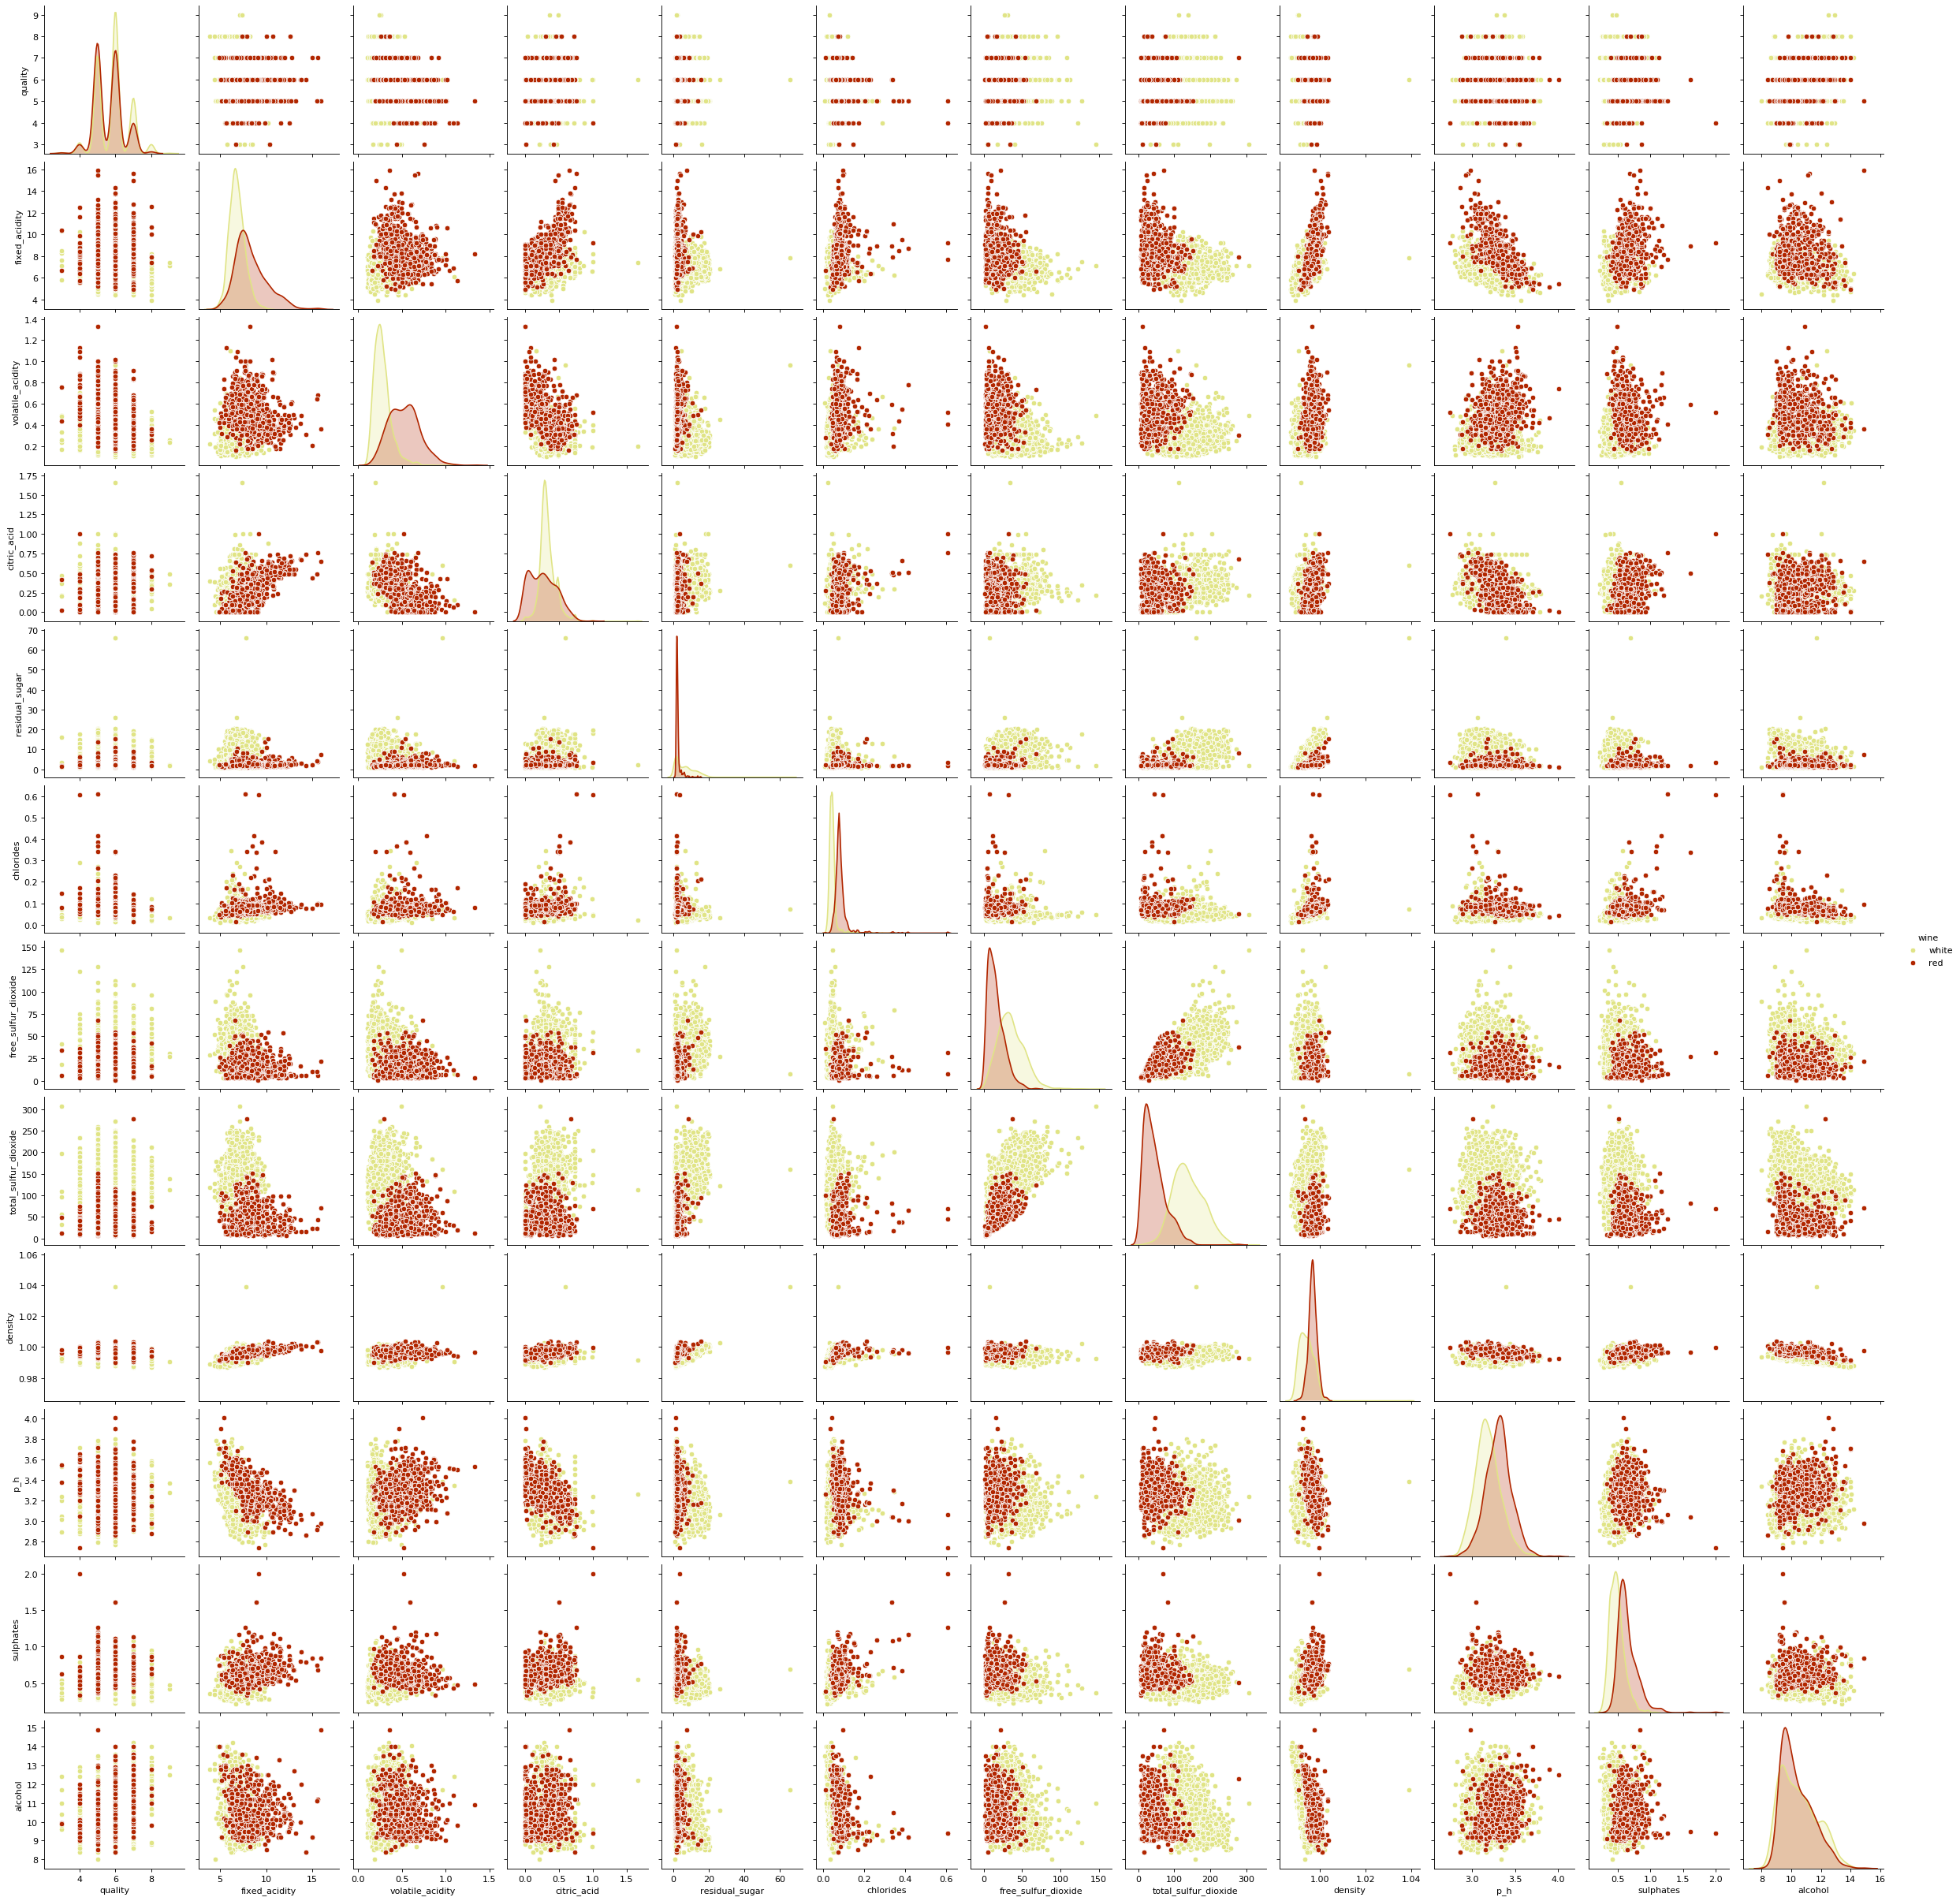

In [59]:
sns.pairplot(wine_train, hue='wine', palette={'red': '#b12600', 'white': '#e0e486'})
plt.show()

We notice that there are quite some skewed variables, which we will log-transform later on to make them be easier to use in modelling. Besides that this plot shows very nicely that white and red wine are very different in their chemical mixture, how interesting!

How exactly do the parameters behave with respect to each other? With a correlation matrix we can take a look at how the non-categorical parameters are correlated with each other, the non-categorical feature `wine` is quickly transformed using `pd.get_dummies` so that it can also join the correlation party

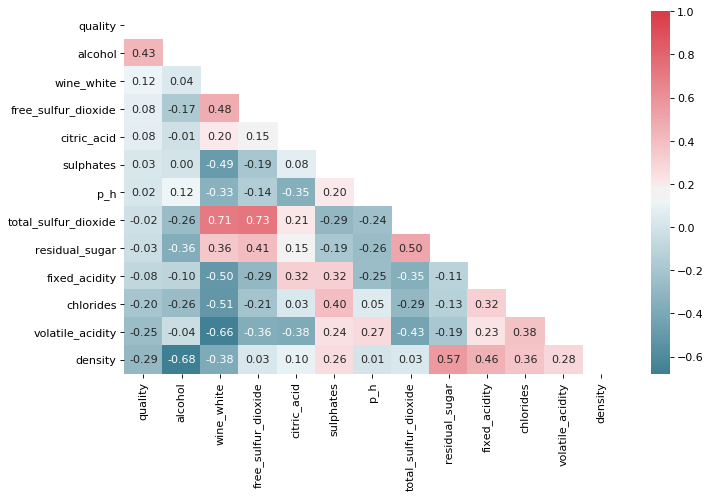

In [6]:
wine_temp = pd.get_dummies(wine_train, drop_first = True)

corr = wine_temp.corr()
top_corr_cols = corr.quality.sort_values(ascending=False).keys()
top_corr = corr.loc[top_corr_cols, top_corr_cols]
dropSelf = np.zeros_like(top_corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
sns.heatmap(top_corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=dropSelf)
plt.show()
del corr, dropSelf, top_corr

In general, we do not see very strong correlations, but we do notice:
* `total_sulfur_dioxide` and `free_sulfur_dioxide` correlate strongly. This is obvious, since total sulfur dioxide is the sum total of the bound and the free sulfur dioxide.  
* `density` and `alcohol` correlate negatively. This makes, after some research, sense since the density is used to determine the amount of alcohol in a wine. [[source](https://www.chemwine.com/home/why-is-wine-density-important-1-sl6yl)]
* `wine_white` and `volatile_acidity` also correlate very negatively. This is also expected, since white wine generally has a lower limit of volatile acidity than red wine. [[source](https://waterhouse.ucdavis.edu/whats-in-wine/volatile-acidity)]
* The only big correlation with the `quality` appears to be the amount of alcohol. We will come back to this after the modelling.

Below we find the function that handles the data preprocessing:

In [70]:
def preprocessing(data, scaled=True):
    '''
    Does some preprocessing on the data
    Input:
    - pd.DataFrame on which we will perform the pre-processing
    - A boolean 'scaled' to indicate whether we want to scale the data
    Output:
    - pd.DataFrame X containing the features we want to model
    - Quality score column y
    '''
    
    # Make a copy of the data to keep the original data untouched
    X = data.copy()
    
    # log-transform the skewed data
    X['log_sulphates'] = np.log(X['sulphates'])
    X['log_density'] = np.log(X['density'])
    X['log_residual_sugar'] = np.log(X['residual_sugar'])
    X['log_volatile_acidity'] = np.log(X['volatile_acidity'])
    X['log_fixed_acidity'] = np.log(X['fixed_acidity'])
    X['log_residual_sugar'] = np.log(X['residual_sugar'])
    X['log_chlorides'] = np.log(X['chlorides'])
    X['log_free_sulfur_dioxide'] = np.log(X['free_sulfur_dioxide'])
    
    # Change white wine to 0 and red wine to 1
    X['wine'] = X['wine'].apply(lambda x: 0 if x == "white" else 1)
    
    # discretizing the quality parameter
    X['quality_cat'] = pd.cut(x=X['quality'], bins=[0, 4, 5, 6, 10], 
               labels=['0_Poor', '1_Average', '2_Good', '3_Excellent'])
    
    # set y to be the quality parameter
    y = X['quality_cat']
    
    # drop the non-log transformed columns and the quality-related columns
    X = X.drop(columns = ['sulphates', 'density', 'residual_sugar',
                          'fixed_acidity','residual_sugar', 'chlorides',
                          'free_sulfur_dioxide', 'quality', 'quality_cat'])
    
    # Scale the data if desired
    if scaled == True:
        X = X.apply(scale)
    
    return X, y

Pepare the data for modelling:

In [71]:
# training data
X, y = preprocessing(wine_train)                     

# test data
X_test, y_test = preprocessing(wine_test)

Let us have a quick look at what the size of the different classes is:

In [72]:
y.value_counts().sort_index()

0_Poor          110
1_Average      1019
2_Good         1317
3_Excellent     554
Name: quality_cat, dtype: int64

We immediately note that the `Poor` class is very small compared to the other 3 classes. This poses an imbalance that is difficult when trying to model the data, more on this in the next section.

## 3. Model Fitting and Tuning

Multiple different models have been fitted (their implementation can be found in the supp_mat.ipynb file) and the following table summarizes our findings ranked by their average accuracy:

| Method  | Average accuracy | Reason for rejection |
| ------------- | ------------- | ------------- |
| Random Forest classifier | 0.64  | black box method|
| Decision tree classifier  | 0.56  | method is known for overfitting and being unstable|
| Support vector machine| 0.53 | -|
| KNeighbors Classifier  |  0.53 |has a very low recall and f1 score for class 'Poor' |
| Logistic regression  |  0.45  |Not a very good accuracy|

We notice that the random forest clearly has the highest accuracy. However, we want an accurate *and explainable* model and the random forest classifier is very much a 'black box' model. The K Neighborhoods classifier only classifies some wines in our test data when the `n_neighbors` parameter is below 5, we severely risk overfitting at this point and therefore discard the method. The decision tree classifier is quite accurate, but the method is unstabe and produces inconsistent results. Finally, we discard logistic regression since the accuracy is just lower than teh SVM method, our method of choice.

Let us now start with tuning our SVM model. Since SVM deals with distances we use scaled data instead of our 'usual' features. To get the best SVM model, we first want to determine which kernel we are going to use and how severly we want to regularize. A gridsearch is not used, since we want to prevent making a model that overfits the data with a value for `C` that is way too low. Instead, we will manually pick a value for `C`.

To make a decision for our final model, we plot the accuracy for different kernels:

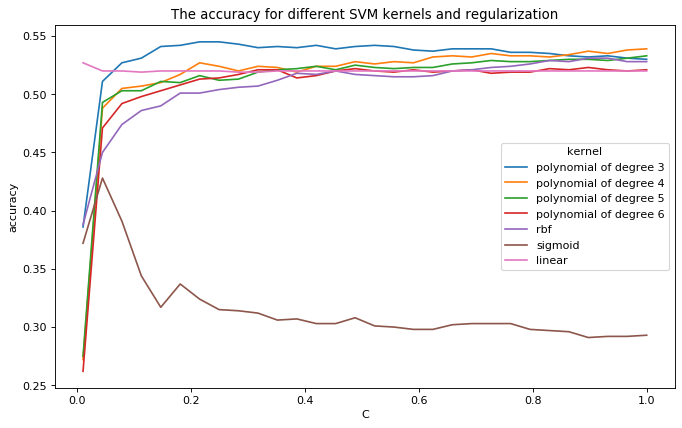

In [73]:
N=30
res_poly_3 = np.zeros(N)
res_poly_4 = np.zeros(N)
res_poly_5 = np.zeros(N)
res_poly_6 = np.zeros(N)
res_rbf = np.zeros(N)
res_sig = np.zeros(N)
res_lin = np.zeros(N)
Cs = np.linspace(0.01, 1, N)
i=0
for C in Cs:
    m_lin = LinearSVC( C=C, class_weight='balanced', max_iter = 20000).fit(X, y)
    res_lin[i] = m_lin.score(X_test, y_test)
    m_poly_3 = SVC(kernel='poly', C=C, degree=3, gamma='scale', class_weight='balanced').fit(X, y)
    res_poly_3[i] = m_poly_3.score(X_test, y_test)
    m_poly_4 = SVC(kernel='poly', C=C, degree=4, gamma='scale', class_weight='balanced').fit(X, y)
    res_poly_4[i] = m_poly_4.score(X_test, y_test)
    m_poly_5 = SVC(kernel='poly', C=C, degree=5, gamma='scale', class_weight='balanced').fit(X, y)
    res_poly_5[i] = m_poly_5.score(X_test, y_test)
    m_poly_6 = SVC(kernel='poly', C=C, degree=6, gamma='scale', class_weight='balanced').fit(X, y)
    res_poly_6[i] = m_poly_6.score(X_test, y_test)
    m_rbf = SVC(kernel='rbf', C=C, gamma='scale', class_weight='balanced').fit(X, y)
    res_rbf[i] = m_rbf.score(X_test, y_test)
    m_sig = SVC(kernel='sigmoid', C=C, gamma='scale', class_weight='balanced').fit(X, y)
    res_sig[i] = m_sig.score(X_test, y_test)
    i+=1

plt.plot(Cs, res_poly_3, label='polynomial of degree 3')
plt.plot(Cs, res_poly_4, label='polynomial of degree 4')
plt.plot(Cs, res_poly_5, label='polynomial of degree 5')
plt.plot(Cs, res_poly_6, label='polynomial of degree 6')
plt.plot(Cs, res_rbf, label='rbf')
plt.plot(Cs, res_sig, label='sigmoid')
plt.plot(Cs, res_lin, label='linear')

plt.legend(title='kernel')
plt.xlabel('C')
plt.ylabel('accuracy')
plt.title('The accuracy for different SVM kernels and regularization')
plt.show()

We immediately notice that the sigmoid kernel does not work well. Since we want to keep our model flexible and prevent overfitting we try to keep `C` as low as possible without ruining accuracy, we stick with 0.5. We see that the polynomial and linear model perform best and behave very similarly. However, accuracy is not the whole picture and while trying to find the best model and since the interpretability of linear models is much better than nonlinear ones, we pick the linear model. We lose a little bit of accuracy compared to e.g. polynomial kernels, but the discussion becomes way more interesting with a linear model, since we can talk about e.g. the weights of the features.  Finally, because of the imbalance in our data, we set `class_weight='balanced'`, this adjust weights inversely proportional to class frequencies, if we don't do this we will run into problems with our small set of poor wines.

We create the function `model_fit`, which performs all the steps needed to run the model:

In [54]:
def model_fit(data):
    '''
    Does everything to get from the raw data to the model
    Input:
    - pd.dataframe of the data
    Output:
    - Our fitted model
    '''
    X, y = preprocessing(data)
    model = LinearSVC(C=0.5,
                      class_weight='balanced',
                      max_iter = 20000).fit(X, y)

    return model

# to be more efficient in the discussion, we run the model now and save it
disc_model = model_fit(wine_train)

# 4. Discussion


Let's start the discussion with a classification report:

In [74]:
print(classification_report(y_test, disc_model.predict(X_test)))

              precision    recall  f1-score   support

      0_Poor       0.25      0.36      0.30        44
   1_Average       0.58      0.72      0.64       325
      2_Good       0.56      0.37      0.44       429
 3_Excellent       0.44      0.56      0.50       202

    accuracy                           0.52      1000
   macro avg       0.46      0.50      0.47      1000
weighted avg       0.53      0.52      0.51      1000



We immediately notice an accuracy of around 50%, which is not an extremely good indicator, we could have done better using random forests, right? Well, that is true, but when we look at the `recall` column, we see that all our recall values are between 36-72%. Other models had a very low score for, especially, the `poor` feature. Falsely classifying a poor wine as 'good', 'average' or even 'excellent' is in a lot of ways an undesirable situation, so we want this recall to be as high as possible. 

What about the confusion matrix of our model?

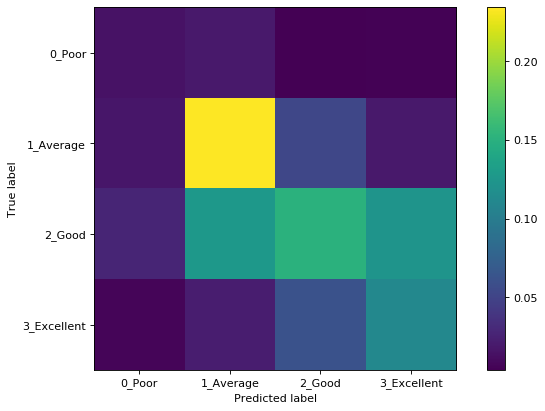

In [50]:
plot_confusion_matrix(disc_model, X_test, y_test, include_values=False, normalize='all')
plt.show()

From the confusion matrix we can indeed see that there are very few poor wines classified as something else than a poor wine. which was the most undirable situation. There are a couple of average and good wines classified as poor, which is not as undesirable as the other way around; it is quite a nice surprise to buy a wine you supposed was very poor, drink it and discover it's actually quite a decent wine. 

The biggest amount of wines in our training data is either average or good, we note that the model classfies them pretty well, except that there are quite some good wines classified as average. This is from the consumer point of view not a big deal, since the average consumer probably barely notices this.

The precision of the excellent wines is not great, and we see this in the confustion matrix; there are quite some good wines labelled as exellent, the biggest flaw of this model. Excellent wines are made to be the absolute best and come at a much higher price than the others, so classifying a lot of good wines as excellent destorys the luxurious and exclusive character of these wines. When you buy an excellent wine as a true wine lover and enthousiast, you don't want to end up with a "good" wine.

But what makes a good wine a good wine and a poor wine a poor wine?

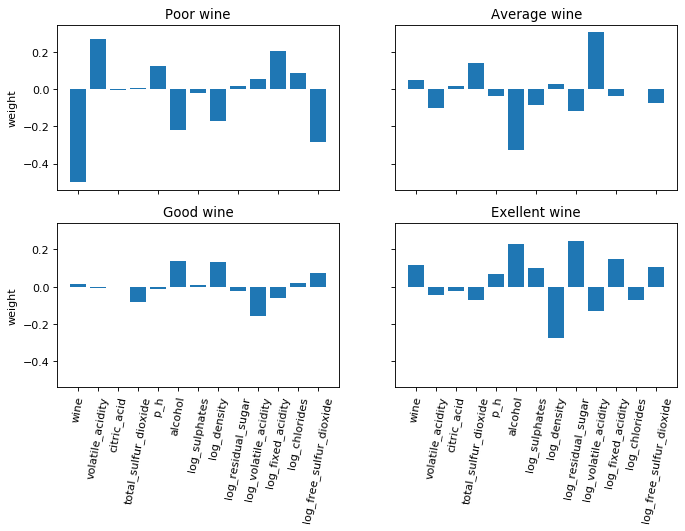

In [77]:
y_pos = np.arange(len(X.columns))

fig, axs = plt.subplots(2, 2, sharey=True)

axs[0, 0].bar(y_pos, disc_model.coef_[0])
axs[0, 0].set_title('Poor wine')
axs[0, 1].bar(y_pos, disc_model.coef_[1])
axs[0, 1].set_title('Average wine')
axs[1, 0].bar(y_pos, disc_model.coef_[2])
axs[1, 0].set_title('Good wine')
plt.sca(axs[1, 0])
plt.xticks(y_pos, X.columns, rotation=80)
axs[1, 1].bar(y_pos, disc_model.coef_[3])
axs[1, 1].set_title('Exellent wine')
plt.sca(axs[1, 1])
plt.xticks(y_pos, X.columns, rotation=80)

for ax in axs.flat:
    ax.set(ylabel='weight')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

**Poor wines**

The biggest influence on classifying a wine as 'poor' is the type of wine. White wines tend to be classied as a poor wine earlier than red wines (recall: white wines are labelled as 0, red ones as 1). Since the dataset is so small, it is difficult to draw conclusions on the other features. 

**Average and good wines**

Most of the wines lay in the average/good space, we notice that the features that decide whether a wine is good or average is the amount of alcohol and the volatile acidity. A combination of a lower amount of alcohol and a higher acidity make a wine average where the complement of that classifies as a good wine. Already during the explanatory data analysis we saw that alcohol and quality were correlated and it is nice to see that back here with the feature weights. What is very interesting to note is that between the average and good wines, a feature with a positive weight for a good wine generally has a negative weight for an average wine, this really shows the model at work.

**Excellent wines**

A lower density, and higher amounts of residual sugar and alcohol are the indicators of an excellent wine.


We notice that the features `citric_acid`, `p_h`, `sulphates` and `chlorides` have almost no impact in our model. Using e.g. PCA we could have gotten rid of those, but since this is not covered in the course we won't do that now.

To summarize we can say that we found at most a "decent" model. Although we do see that there are features that indicate whether a wine is good or poor and that we are able to classify wines somewhat in the right class, we cannot ignore the fact that we only have an accuracy of just above 50%. The small set of poor wines makes it difficult to model the data and something that we should also not forget is that in the end the wines in the data are classified by humans, a very subjective process which makes quantitative modelling ever harder.

## 5. Model Validation

We now want to look at the performance of our model on the holdout data and we start by reading this data and the preprocessing.

In [78]:
wine_holdout = pd.read_csv("wine_qual_holdout.csv")

X_holdout, y_holdout = preprocessing(wine_holdout)

To give the model more data to train on, we merge the train and test data and apply the model on this merged data.

In [79]:
# create a dataframe with both the test and the training data
wine_merged = pd.concat([wine_train, wine_test])

# The final model
final_model = model_fit(wine_merged)

Next up, we look at the confusion matrix, we see that it is very similar to the one in section 4, which shows that our model is giving us consistent results.

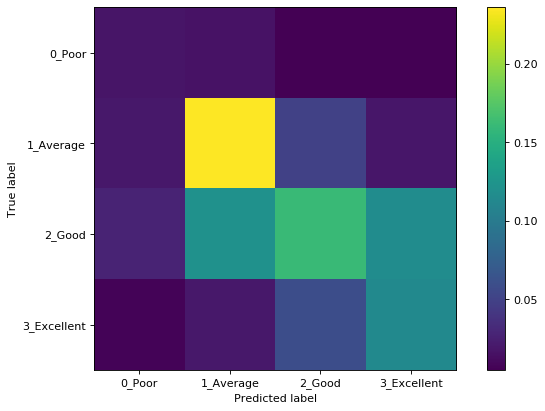

In [80]:
plot_confusion_matrix(final_model, X_holdout, y_holdout, include_values=False, normalize='all')
plt.show()

Finally, the classification report.

In [81]:
print(classification_report(y_holdout, final_model.predict(X_holdout)))

              precision    recall  f1-score   support

      0_Poor       0.25      0.41      0.31        44
   1_Average       0.60      0.73      0.66       325
      2_Good       0.58      0.38      0.46       429
 3_Excellent       0.45      0.57      0.50       202

    accuracy                           0.53      1000
   macro avg       0.47      0.52      0.48      1000
weighted avg       0.55      0.53      0.53      1000



With the holdout data we see that we even get a model that is a littlebit more accurate. Almost all the percentages are equal or 1-2% off from the model from before. We still have troubles with the poor class, but we do have a relatively high recall, and the recall of the good class is still not great. We still classify quite some good wines as average or excellent. the conclusion from the holdout data is that our model is very consistent.

Cheers!